# Lab: Visualization and Imputation (AAVAIL, US & Singapore)

This notebook follows a guided lab structure to analyze the AAVAIL dataset. We will focus on:

1.  Loading and inspecting the data.
2.  Identifying and visualizing missing data.
3.  Imputing missing values using appropriate techniques.
4.  Visualizing business insights for the US and Singapore markets.
5.  Summarizing takeaways for stakeholders.

**Libraries Used:**

* `pandas`
* `numpy`
* `matplotlib`
* `seaborn`


# --- 1. Setup and Data Loading ---


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set a consistent style for all plots
sns.set_theme(style="whitegrid")

# Configure paths
BASE_DIR = Path("..")
RAW_DATA_PATH = BASE_DIR / "data" / "raw" / "aavail_customer_activity.csv"
PROCESSED_DATA_PATH = BASE_DIR / "data" / "processed" / "aavail_data_imputed.csv"
REPORT_PATH = BASE_DIR / "reports" / "aavail_market_insights.html"
ASSETS_DIR = BASE_DIR / "reports" / "assets"
ASSETS_DIR.mkdir(parents=True, exist_ok=True)


## Step 1: Load and Inspect Data

Load the dataset using Pandas and inspect its structure and summary statistics.


In [8]:
# Load the dataset
file_name = RAW_DATA_PATH

try:
    df = pd.read_csv(file_name)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
    print("Please upload the file to your Colab session and try again.")
    # Create a dummy dataframe to allow subsequent cells to run without error
    df = pd.DataFrame()

if not df.empty:
    # Display the first 5 rows
    print("\n--- Head ---")
    print(df.head())
    
    # Display data structure and types
    print("\n--- Info ---")
    df.info()
    
    # Display summary statistics for numerical columns
    print("\n--- Describe (Numerical) ---")
    print(df.describe())
    
    # Display summary for categorical columns
    print("\n--- Describe (Categorical) ---")
    print(df.describe(include=['object', 'bool']))


Dataset loaded successfully.

--- Head ---
   customer_id   country_name   age     customer_name  is_subscriber  \
0            1  united_states  21.0        Kasen Todd           True   
1            2      singapore  31.0      Ensley Garza          False   
2            3  united_states  22.0     Lillian Carey          False   
3            4  united_states  21.0  Beau Christensen           True   
4            5      singapore  22.0    Ernesto Gibson           True   

  subscriber_type  num_streams  
0  aavail_premium         23.0  
1             NaN         12.0  
2  aavail_premium         22.0  
3    aavail_basic         19.0  
4  aavail_premium         23.0  

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      1000 non-null   int64  
 1   country_name     1000 non-null   object 
 2   age              1

## Step 2: Identify and Visualize Missing Data

We will create a heatmap to quickly identify patterns in missing data and then summarize the exact percentages.


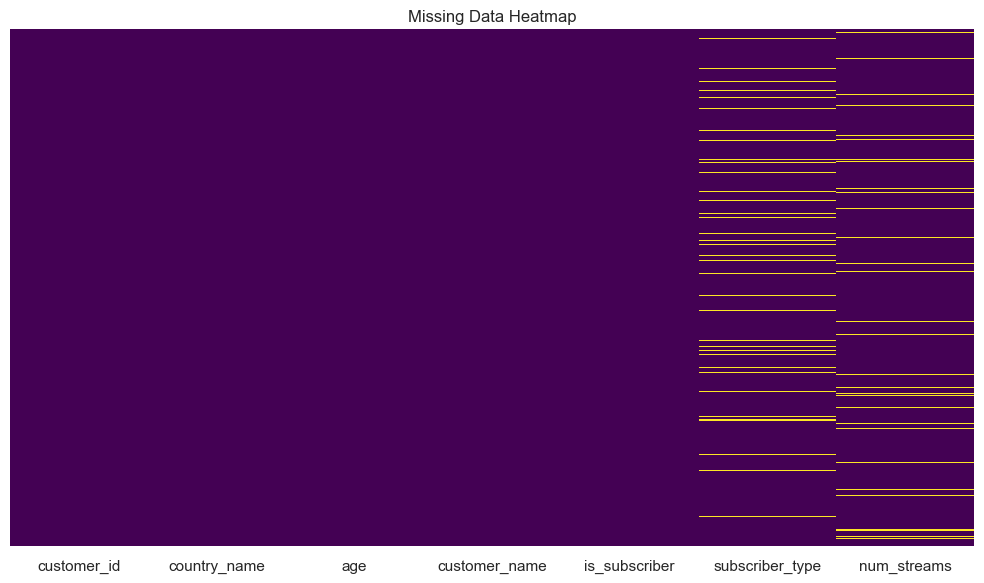


--- Missing Data Summary ---
                 Missing Count  Missing Percentage
subscriber_type             72                 7.2
num_streams                 46                 4.6

Overall percentage of missing data: 1.69%


In [9]:
if not df.empty:
    # Create a missingness heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title('Missing Data Heatmap')
    plt.tight_layout()
    missing_heatmap_path = ASSETS_DIR / "missingness_heatmap.png"
    plt.savefig(missing_heatmap_path, dpi=150, bbox_inches="tight")
    plt.show()
    
    # Summarize missing data per column - only show columns with missing data
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data / len(df)) * 100
    missing_summary = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing Percentage': missing_percentage
    })
    # Filter to only show columns with missing data
    missing_summary = missing_summary[missing_summary['Missing Count'] > 0]
    print("\n--- Missing Data Summary ---")
    print(missing_summary.sort_values(by='Missing Count', ascending=False))
    
    overall_percentage = (df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100
    print(f"\nOverall percentage of missing data: {overall_percentage:.2f}%")


**Missing Data Analysis:**

The heatmap and summary table show two columns with missing data:

1.  `subscriber_type` (Categorical) - 72 missing values (7.2%)
2.  `num_streams` (Numeric) - 46 missing values (4.6%)

`subscriber_type` is missing a significant number of values, which is problematic as it's a key business metric. `num_streams` is missing fewer values but still needs to be addressed.

## Step 3: Impute Missing Data

We will impute the missing values using appropriate techniques:

* **`num_streams` (Numeric):** We will use the **median** value. The median is more robust to outliers than the mean.
* **`subscriber_type` (Categorical):** We will use the **mode** (the most frequent value). This is a standard approach for categorical data.

We will create a copy of the dataframe for imputation to show "before vs. after."


In [10]:
if not df.empty:
    # Create a copy for imputation
    df_imputed = df.copy()
    
    # Track which values were missing before imputation
    age_missing_mask = df_imputed['age'].isnull()
    streams_missing_mask = df_imputed['num_streams'].isnull()
    subscriber_missing_mask = df_imputed['subscriber_type'].isnull()
    
    # Count missing values before imputation
    age_missing_count = age_missing_mask.sum()
    streams_missing_count = streams_missing_mask.sum()
    subscriber_missing_count = subscriber_missing_mask.sum()
    
    print(f"--- Missing Values Before Imputation ---")
    print(f"Age: {age_missing_count} ({age_missing_count/len(df)*100:.2f}%)")
    print(f"Num Streams: {streams_missing_count} ({streams_missing_count/len(df)*100:.2f}%)")
    print(f"Subscriber Type: {subscriber_missing_count} ({subscriber_missing_count/len(df)*100:.2f}%)")
    
    # --- Imputation Strategy ---
    # 1. For 'age' and 'num_streams', use the median (calculated from non-missing values)
    median_age = df_imputed['age'].median()
    median_streams = df_imputed['num_streams'].median()
    
    # 2. For 'subscriber_type', use the mode
    # .mode() returns a Series, so we take the first item [0]
    mode_subscriber_type = df_imputed['subscriber_type'].mode()[0]
    
    print(f"\n--- Imputation Values ---")
    print(f"Imputing 'age' with median: {median_age}")
    print(f"Imputing 'num_streams' with median: {median_streams}")
    print(f"Imputing 'subscriber_type' with mode: '{mode_subscriber_type}'")
    
    # --- Apply Imputation ---
    # Use direct assignment to ensure the operation works correctly
    df_imputed.loc[age_missing_mask, 'age'] = median_age
    df_imputed.loc[streams_missing_mask, 'num_streams'] = median_streams
    df_imputed.loc[subscriber_missing_mask, 'subscriber_type'] = mode_subscriber_type
    
    # --- Verify Cleanup ---
    print("\n--- Missing Data Summary (After Imputation) ---")
    print(df_imputed.isnull().sum())
    
    # Verify imputation worked
    if df_imputed['age'].isnull().sum() == 0:
        print(f"\n✓ Age imputation successful: {age_missing_count} values imputed with {median_age}")
    if df_imputed['num_streams'].isnull().sum() == 0:
        print(f"✓ Num Streams imputation successful: {streams_missing_count} values imputed with {median_streams}")
    if df_imputed['subscriber_type'].isnull().sum() == 0:
        print(f"✓ Subscriber Type imputation successful: {subscriber_missing_count} values imputed with '{mode_subscriber_type}'")
    
    # Save the imputed dataset
    df_imputed.to_csv(PROCESSED_DATA_PATH, index=False)
    print(f"\nImputed dataset saved to {PROCESSED_DATA_PATH}")


--- Missing Values Before Imputation ---
Age: 0 (0.00%)
Num Streams: 46 (4.60%)
Subscriber Type: 72 (7.20%)

--- Imputation Values ---
Imputing 'age' with median: 24.0
Imputing 'num_streams' with median: 19.0
Imputing 'subscriber_type' with mode: 'aavail_basic'

--- Missing Data Summary (After Imputation) ---
customer_id        0
country_name       0
age                0
customer_name      0
is_subscriber      0
subscriber_type    0
num_streams        0
dtype: int64

✓ Age imputation successful: 0 values imputed with 24.0
✓ Num Streams imputation successful: 46 values imputed with 19.0
✓ Subscriber Type imputation successful: 72 values imputed with 'aavail_basic'

Imputed dataset saved to ../data/processed/aavail_data_imputed.csv


### Visualize Imputation: Before and After

Let's plot the distributions for `num_streams` and `subscriber_type` to visualize the imputation impact for the fields with missing data.


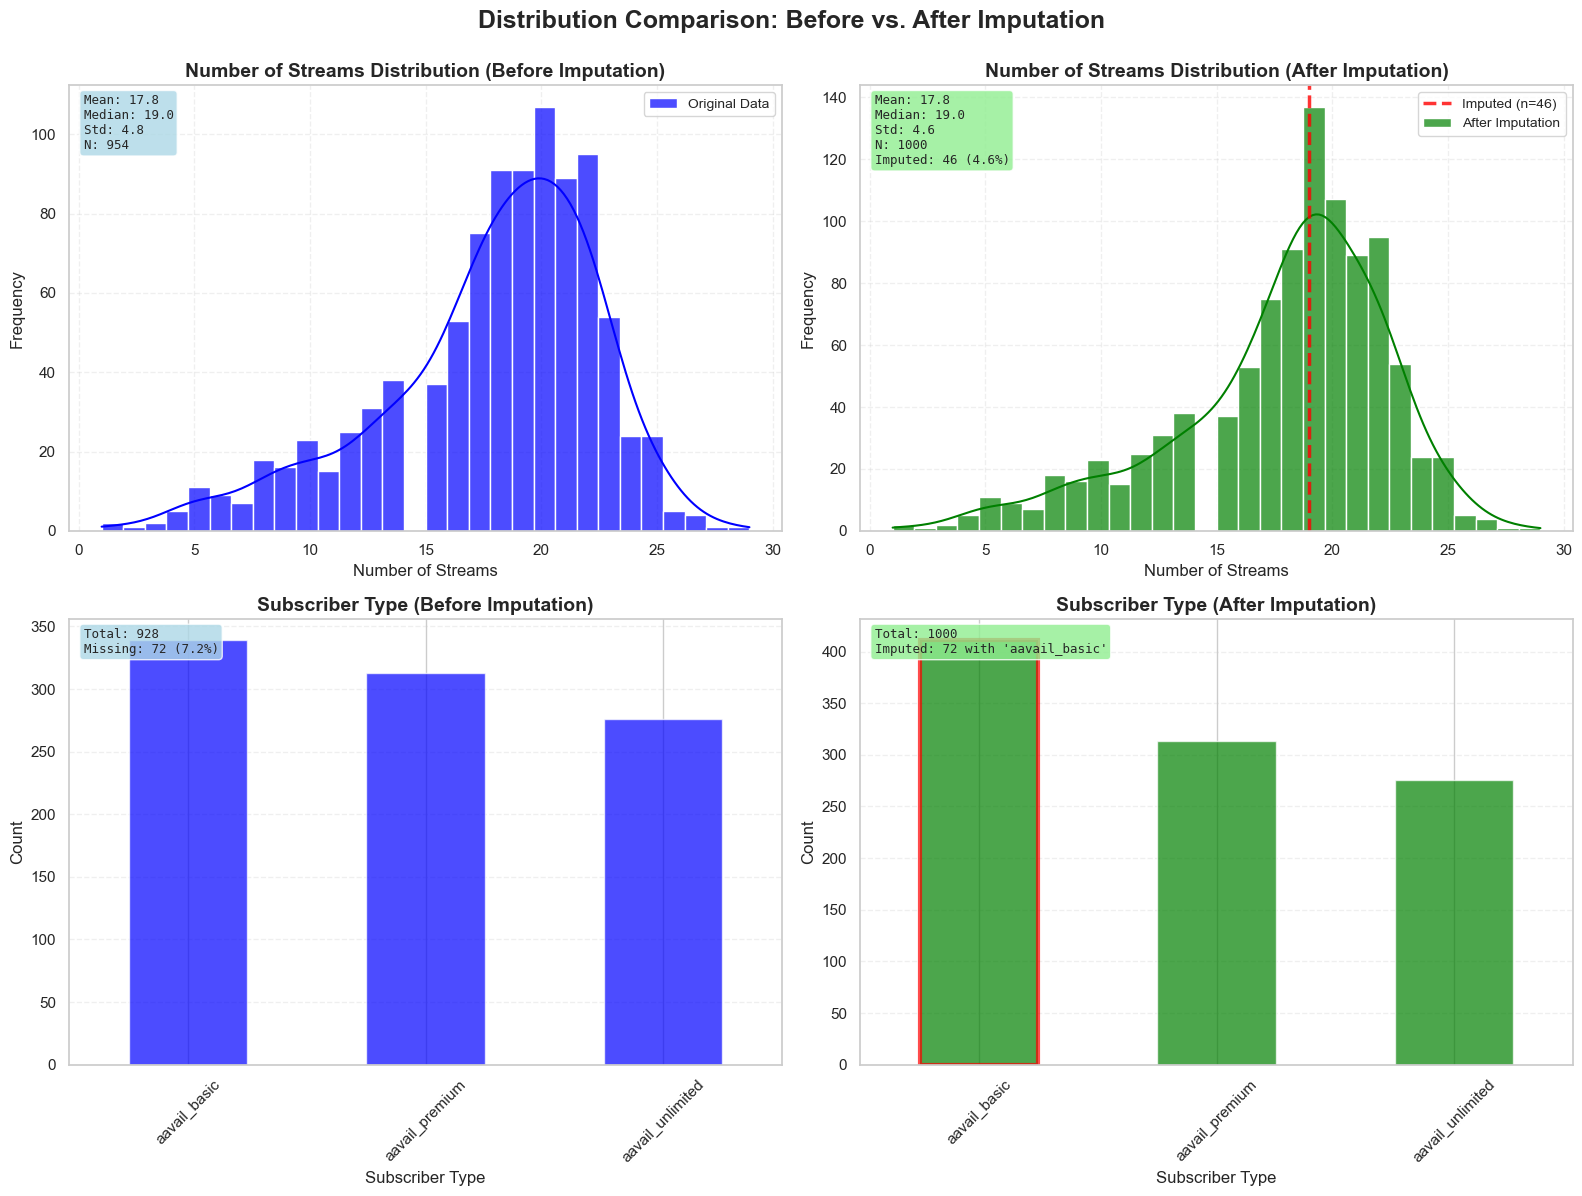


IMPUTATION IMPACT SUMMARY

Num Streams:
  Before Imputation:
    Count: 954
    Mean: 17.78
    Median: 19.00
    Std Dev: 4.75
  After Imputation:
    Count: 1000 (added 46 imputed values)
    Mean: 17.84 (change: 0.0561)
    Median: 19.00 (change: 0.0000)
    Std Dev: 4.65 (change: -0.1037)
    Imputed Value: 19.00 (used for 46 missing values)
    Impact: Minimal

Subscriber Type:
  Before Imputation:
    Total Count: 928
    Missing: 72 (7.20%)
    Distribution:
      aavail_basic: 339
      aavail_premium: 313
      aavail_unlimited: 276
  After Imputation:
    Total Count: 1000
    Imputed Value: 'aavail_basic' (used for 72 missing values)
    Distribution:
      aavail_basic: 411 (+72)
      aavail_premium: 313
      aavail_unlimited: 276


In [11]:
if not df.empty:
    # Track which values were imputed
    streams_missing_mask = df['num_streams'].isnull()
    subscriber_missing_mask = df['subscriber_type'].isnull()
    
    # Get data before and after imputation for num_streams
    streams_before = df['num_streams'].dropna()
    streams_after = df_imputed['num_streams']
    streams_imputed_count = streams_missing_mask.sum()
    streams_imputed_value = df_imputed.loc[streams_missing_mask, 'num_streams'].iloc[0] if streams_imputed_count > 0 else None
    
    # Get data for subscriber_type (categorical)
    subscriber_before = df['subscriber_type'].value_counts()
    subscriber_after = df_imputed['subscriber_type'].value_counts()
    subscriber_imputed_count = subscriber_missing_mask.sum()
    subscriber_imputed_value = df_imputed.loc[subscriber_missing_mask, 'subscriber_type'].iloc[0] if subscriber_imputed_count > 0 else None
    
    # Create 2x2 grid layout: num_streams (top row), subscriber_type (bottom row)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Distribution Comparison: Before vs. After Imputation', fontsize=18, fontweight='bold', y=0.995)
    
    # --- Top Row: Num Streams Distribution ---
    # Before Imputation (top left)
    sns.histplot(streams_before, kde=True, ax=axes[0, 0], color='blue', label='Original Data', bins=30, alpha=0.7)
    axes[0, 0].set_title('Number of Streams Distribution (Before Imputation)', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Number of Streams', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    axes[0, 0].legend(fontsize=10, loc='upper right')
    axes[0, 0].grid(True, alpha=0.3, linestyle='--')
    
    # Add statistics box for before
    stats_before = f"Mean: {streams_before.mean():.1f}\nMedian: {streams_before.median():.1f}\nStd: {streams_before.std():.1f}\nN: {len(streams_before)}"
    axes[0, 0].text(0.02, 0.98, stats_before, transform=axes[0, 0].transAxes,
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8), fontsize=9, family='monospace')
    
    # After Imputation (top right)
    sns.histplot(streams_after, kde=True, ax=axes[0, 1], color='green', label='After Imputation', bins=30, alpha=0.7)
    axes[0, 1].set_title('Number of Streams Distribution (After Imputation)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Number of Streams', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].legend(fontsize=10, loc='upper right')
    axes[0, 1].grid(True, alpha=0.3, linestyle='--')
    
    # Highlight imputed value if any
    if streams_imputed_value is not None:
        axes[0, 1].axvline(x=streams_imputed_value, color='red', linestyle='--', linewidth=2.5, 
                       label=f'Imputed (n={streams_imputed_count})', alpha=0.8)
        axes[0, 1].legend(fontsize=10, loc='upper right')
    
    # Add statistics box for after
    stats_after = f"Mean: {streams_after.mean():.1f}\nMedian: {streams_after.median():.1f}\nStd: {streams_after.std():.1f}\nN: {len(streams_after)}"
    if streams_imputed_count > 0:
        stats_after += f"\nImputed: {streams_imputed_count} ({streams_imputed_count/len(df)*100:.1f}%)"
    axes[0, 1].text(0.02, 0.98, stats_after, transform=axes[0, 1].transAxes,
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8), fontsize=9, family='monospace')
    
    # --- Bottom Row: Subscriber Type Distribution ---
    # Before Imputation (bottom left)
    subscriber_before.plot(kind='bar', ax=axes[1, 0], color='blue', alpha=0.7)
    axes[1, 0].set_title('Subscriber Type (Before Imputation)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Subscriber Type', fontsize=12)
    axes[1, 0].set_ylabel('Count', fontsize=12)
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3, linestyle='--', axis='y')
    axes[1, 0].text(0.02, 0.98, f"Total: {subscriber_before.sum()}\nMissing: {subscriber_imputed_count} ({subscriber_imputed_count/len(df)*100:.1f}%)", 
                transform=axes[1, 0].transAxes, verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8), fontsize=9, family='monospace')
    
    # After Imputation (bottom right)
    subscriber_after.plot(kind='bar', ax=axes[1, 1], color='green', alpha=0.7)
    axes[1, 1].set_title('Subscriber Type (After Imputation)', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Subscriber Type', fontsize=12)
    axes[1, 1].set_ylabel('Count', fontsize=12)
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3, linestyle='--', axis='y')
    if subscriber_imputed_value is not None:
        # Highlight the imputed value
        imputed_idx = list(subscriber_after.index).index(subscriber_imputed_value)
        axes[1, 1].patches[imputed_idx].set_edgecolor('red')
        axes[1, 1].patches[imputed_idx].set_linewidth(3)
    axes[1, 1].text(0.02, 0.98, f"Total: {subscriber_after.sum()}\nImputed: {subscriber_imputed_count} with '{subscriber_imputed_value}'", 
                transform=axes[1, 1].transAxes, verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8), fontsize=9, family='monospace')
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / "imputation_comparison.png", dpi=150, bbox_inches="tight")
    plt.show()
    
    # Print detailed summary statistics
    print("\n" + "="*60)
    print("IMPUTATION IMPACT SUMMARY")
    print("="*60)
    print(f"\nNum Streams:")
    print(f"  Before Imputation:")
    print(f"    Count: {len(streams_before)}")
    print(f"    Mean: {streams_before.mean():.2f}")
    print(f"    Median: {streams_before.median():.2f}")
    print(f"    Std Dev: {streams_before.std():.2f}")
    print(f"  After Imputation:")
    print(f"    Count: {len(streams_after)} (added {streams_imputed_count} imputed values)")
    print(f"    Mean: {streams_after.mean():.2f} (change: {streams_after.mean() - streams_before.mean():.4f})")
    print(f"    Median: {streams_after.median():.2f} (change: {streams_after.median() - streams_before.median():.4f})")
    print(f"    Std Dev: {streams_after.std():.2f} (change: {streams_after.std() - streams_before.std():.4f})")
    if streams_imputed_count > 0:
        print(f"    Imputed Value: {streams_imputed_value:.2f} (used for {streams_imputed_count} missing values)")
        print(f"    Impact: {'Minimal' if abs(streams_after.mean() - streams_before.mean()) < 0.1 else 'Noticeable'}")
    
    print(f"\nSubscriber Type:")
    print(f"  Before Imputation:")
    print(f"    Total Count: {subscriber_before.sum()}")
    print(f"    Missing: {subscriber_imputed_count} ({subscriber_imputed_count/len(df)*100:.2f}%)")
    print(f"    Distribution:")
    for stype, count in subscriber_before.items():
        print(f"      {stype}: {count}")
    print(f"  After Imputation:")
    print(f"    Total Count: {subscriber_after.sum()}")
    print(f"    Imputed Value: '{subscriber_imputed_value}' (used for {subscriber_imputed_count} missing values)")
    print(f"    Distribution:")
    for stype, count in subscriber_after.items():
        change = count - subscriber_before.get(stype, 0)
        change_str = f" (+{change})" if change > 0 else ""
        print(f"      {stype}: {count}{change_str}")
    print("="*60)


**Imputation Visualization Analysis:**

The visualization shows a 2x2 grid comparing distributions before and after imputation for `num_streams` and `subscriber_type`. Key observations:

1. **Number of Streams (Top Row)**: 
   - The "After" plot shows all values (including imputed ones), while the "Before" plot shows only non-missing values. The red dashed line in the "After" plot highlights the imputed value (median).
   - If the distributions look similar, this indicates that the median value used for imputation is representative and didn't introduce significant bias.

2. **Subscriber Type (Bottom Row)**:
   - The bar charts show the distribution of subscriber types before and after imputation.
   - The imputed value (mode) is highlighted with a red border in the "After" plot.
   - This shows how many missing values were filled with the most frequent subscriber type.

3. **Distribution Preservation**: If the distributions look similar, this indicates that:
   - The imputation methods (median for numeric, mode for categorical) are appropriate
   - The number of missing values is relatively small compared to the total dataset
   - The imputation didn't introduce significant bias

4. **Statistics Comparison**: The statistics boxes show:
   - For `num_streams`: Mean, median, and standard deviation before and after imputation
   - For `subscriber_type`: Total counts and missing/imputed counts
   - The count of imputed values and their percentage
   - This helps verify that imputation is working correctly

5. **Impact Assessment**: Check the printed summary statistics to see:
   - How many values were imputed for each field
   - The exact imputed values (median for `num_streams`, mode for `subscriber_type`)
   - The change in distribution statistics
   - Whether the impact is minimal (good) or noticeable (may need review)

## Step 4: Clean Dataset

Our imputation step has handled all missing values. We will now proceed with the cleaned dataset, `df_imputed`.


In [12]:
if not df.empty:
    print("Dataset is clean and ready for analysis.")
    print(f"Total rows: {len(df_imputed)}")


Dataset is clean and ready for analysis.
Total rows: 1000


In [13]:
## Step 5: Visualize Business Insights (US vs. Singapore)

Now we'll use the cleaned data to compare the two markets.


SyntaxError: unterminated string literal (detected at line 3) (1844058467.py, line 3)

In [ ]:
if not df.empty:
    # Separate data by market
    df_us = df_imputed[df_imputed['country_name'] == 'united_states'].copy()
    df_sg = df_imputed[df_imputed['country_name'] == 'singapore'].copy()
    
    print(f"US Market Rows: {len(df_us)}")
    print(f"Singapore Market Rows: {len(df_sg)}")


### Insight 1: Subscriber Type Distribution by Market

How popular is each subscription plan in each country?


if not df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    fig.suptitle('Subscriber Type Distribution by Market')
    
    # US Market
    sns.countplot(data=df_us, x='subscriber_type', ax=axes[0], palette='coolwarm',
                  order=df_imputed['subscriber_type'].value_counts().index)
    axes[0].set_title('United States')
    axes[0].set_xlabel('Subscriber Type')
    axes[0].set_ylabel('Count of Customers')
    
    # Singapore Market
    sns.countplot(data=df_sg, x='subscriber_type', ax=axes[1], palette='coolwarm',
                  order=df_imputed['subscriber_type'].value_counts().index)
    axes[1].set_title('Singapore')
    axes[1].set_xlabel('Subscriber Type')
    axes[1].set_ylabel('') # Remove y-label for clarity
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / "subscriber_type_comparison.png", dpi=150, bbox_inches="tight")
    plt.show()


### Insight 2: Streaming Activity by Subscriber Type

Do customers on different plans stream more or less? We'll use `num_streams` as our KPI.


if not df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
    fig.suptitle('Streaming Activity (num_streams) by Subscriber Type')
    
    plan_order = ['aavail_basic', 'aavail_premium', 'aavail_unlimited']
    
    # US Market
    sns.boxplot(data=df_us, x='subscriber_type', y='num_streams', ax=axes[0], order=plan_order)
    axes[0].set_title('United States')
    axes[0].set_xlabel('Subscriber Type')
    axes[0].set_ylabel('Number of Streams')
    
    # Singapore Market
    sns.boxplot(data=df_sg, x='subscriber_type', y='num_streams', ax=axes[1], order=plan_order)
    axes[1].set_title('Singapore')
    axes[1].set_xlabel('Subscriber Type')
    axes[1].set_ylabel('') # Remove y-label
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / "streams_by_subscriber_type.png", dpi=150, bbox_inches="tight")
    plt.show()


### Insight 3: Subscriber Conversion (is_subscriber)

What is the ratio of subscribers to non-subscribers in each market?


In [ ]:
if not df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    fig.suptitle('Subscriber Status (is_subscriber) by Market')
    
    # US Market
    us_counts = df_us['is_subscriber'].value_counts()
    sns.barplot(x=us_counts.index, y=us_counts.values, ax=axes[0], palette='pastel')
    axes[0].set_title('United States')
    axes[0].set_xlabel('Is Subscriber?')
    axes[0].set_ylabel('Count of Customers')
    axes[0].set_xticklabels(['True (Subscriber)', 'False (Non-Subscriber)'])
    
    # Singapore Market
    sg_counts = df_sg['is_subscriber'].value_counts()
    sns.barplot(x=sg_counts.index, y=sg_counts.values, ax=axes[1], palette='pastel')
    axes[1].set_title('Singapore')
    axes[1].set_xlabel('Is Subscriber?')
    axes[1].set_ylabel('') # Remove y-label
    axes[1].set_xticklabels(['True (Subscriber)', 'False (Non-Subscriber)'])
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / "subscriber_status.png", dpi=150, bbox_inches="tight")
    plt.show()


### Insight 4: Age Demographics by Subscriber Type

Is there a difference in age for customers on various plans?


In [ ]:
if not df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
    fig.suptitle('Age Distribution by Subscriber Type')
    
    plan_order = ['aavail_basic', 'aavail_premium', 'aavail_unlimited']
    
    # US Market
    sns.boxplot(data=df_us, x='subscriber_type', y='age', ax=axes[0], order=plan_order)
    axes[0].set_title('United States')
    axes[0].set_xlabel('Subscriber Type')
    axes[0].set_ylabel('Age')
    
    # Singapore Market
    sns.boxplot(data=df_sg, x='subscriber_type', y='age', ax=axes[1], order=plan_order)
    axes[1].set_title('Singapore')
    axes[1].set_xlabel('Subscriber Type')
    axes[1].set_ylabel('') # Remove y-label
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / "age_by_subscriber_type.png", dpi=150, bbox_inches="tight")
    plt.show()


### Insight 5: Market Churn Analysis

**Understanding Churn:** In this dataset, churn is defined as customers who are no longer subscribed to the service. Specifically, if `is_subscriber = False`, this indicates that the customer has churned (they were previously subscribed based on their `subscriber_type` but are no longer paying customers).

We'll analyze churn rates by:
- Market (US vs Singapore)
- Subscriber Type (the imputed variable)
- Number of Streams (the imputed variable)

This analysis will help identify which segments are most at risk and where AAVAIL should focus retention efforts.


In [ ]:
if not df.empty:
    # Calculate churn rates by market
    # Churn = is_subscriber == False (they have a subscriber_type but are no longer subscribed)
    df_imputed['churned'] = ~df_imputed['is_subscriber']
    
    # Overall churn by market
    churn_by_market = df_imputed.groupby('country_name')['churned'].agg(['sum', 'count', 'mean']).round(3)
    churn_by_market.columns = ['Churned', 'Total', 'Churn_Rate']
    churn_by_market['Churn_Rate_Pct'] = (churn_by_market['Churn_Rate'] * 100).round(1)
    
    print("="*70)
    print("CHURN ANALYSIS SUMMARY")
    print("="*70)
    print("\nOverall Churn by Market:")
    print(churn_by_market[['Churned', 'Total', 'Churn_Rate_Pct']])
    print("\n" + "="*70)
    
    # Create comprehensive churn visualization
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Overall Churn Rate by Market (Top Left)
    ax1 = fig.add_subplot(gs[0, 0])
    market_churn_data = churn_by_market['Churn_Rate_Pct']
    colors = ['#e74c3c' if x > market_churn_data.mean() else '#2ecc71' for x in market_churn_data.values]
    bars = ax1.bar(market_churn_data.index.str.replace('_', ' ').str.title(), 
                   market_churn_data.values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    ax1.set_title('Overall Churn Rate by Market', fontsize=14, fontweight='bold', pad=15)
    ax1.set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Market', fontsize=12, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_ylim(0, max(market_churn_data.values) * 1.2)
    
    # Add value labels on bars
    for bar, val in zip(bars, market_churn_data.values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # 2. Churn Rate by Subscriber Type and Market (Top Right)
    ax2 = fig.add_subplot(gs[0, 1])
    churn_by_type_market = df_imputed.groupby(['country_name', 'subscriber_type'])['churned'].mean() * 100
    churn_by_type_market = churn_by_type_market.unstack(level=0)
    
    x = np.arange(len(churn_by_type_market.index))
    width = 0.35
    us_vals = churn_by_type_market['united_states'].values
    sg_vals = churn_by_type_market['singapore'].values
    
    bars1 = ax2.bar(x - width/2, us_vals, width, label='United States', color='#3498db', alpha=0.7, edgecolor='black')
    bars2 = ax2.bar(x + width/2, sg_vals, width, label='Singapore', color='#e67e22', alpha=0.7, edgecolor='black')
    
    ax2.set_title('Churn Rate by Subscriber Type and Market', fontsize=14, fontweight='bold', pad=15)
    ax2.set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Subscriber Type', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels([st.replace('aavail_', '').title() for st in churn_by_type_market.index], rotation=45, ha='right')
    ax2.legend(fontsize=10)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 3. Churn Rate by Number of Streams (Binned) - Bottom Left
    ax3 = fig.add_subplot(gs[1, 0])
    
    # Create bins for num_streams
    df_imputed['streams_bin'] = pd.cut(df_imputed['num_streams'], 
                                       bins=[0, 10, 15, 20, 25, 30], 
                                       labels=['0-10', '11-15', '16-20', '21-25', '26-30'])
    
    churn_by_streams = df_imputed.groupby('streams_bin')['churned'].agg(['mean', 'count']) * 100
    churn_by_streams.columns = ['Churn_Rate', 'Count']
    
    bars = ax3.bar(churn_by_streams.index.astype(str), churn_by_streams['Churn_Rate'].values,
                   color='#9b59b6', alpha=0.7, edgecolor='black', linewidth=1.5)
    ax3.set_title('Churn Rate by Number of Streams', fontsize=14, fontweight='bold', pad=15)
    ax3.set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Number of Streams (Binned)', fontsize=12, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bar, val, count in zip(bars, churn_by_streams['Churn_Rate'].values, churn_by_streams['Count'].values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%\n(n={count})', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 4. Churn Count Comparison by Market and Subscriber Type (Bottom Right)
    ax4 = fig.add_subplot(gs[1, 1])
    
    churn_counts = df_imputed[df_imputed['churned']].groupby(['country_name', 'subscriber_type']).size().unstack(fill_value=0)
    
    x = np.arange(len(churn_counts.columns))
    width = 0.35
    us_counts = churn_counts.loc['united_states'].values if 'united_states' in churn_counts.index else [0]*len(x)
    sg_counts = churn_counts.loc['singapore'].values if 'singapore' in churn_counts.index else [0]*len(x)
    
    bars1 = ax4.bar(x - width/2, us_counts, width, label='United States', color='#3498db', alpha=0.7, edgecolor='black')
    bars2 = ax4.bar(x + width/2, sg_counts, width, label='Singapore', color='#e67e22', alpha=0.7, edgecolor='black')
    
    ax4.set_title('Churned Customer Count by Subscriber Type and Market', fontsize=14, fontweight='bold', pad=15)
    ax4.set_ylabel('Number of Churned Customers', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Subscriber Type', fontsize=12, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels([st.replace('aavail_', '').title() for st in churn_counts.columns], rotation=45, ha='right')
    ax4.legend(fontsize=10)
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax4.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 5. Average Streams for Churned vs Active Customers (Bottom Row, Spanning Both Columns)
    ax5 = fig.add_subplot(gs[2, :])
    
    streams_comparison = df_imputed.groupby(['country_name', 'churned'])['num_streams'].mean()
    
    # Extract values for each market and churn status
    us_active = streams_comparison.get(('united_states', False), 0)
    us_churned = streams_comparison.get(('united_states', True), 0)
    sg_active = streams_comparison.get(('singapore', False), 0)
    sg_churned = streams_comparison.get(('singapore', True), 0)
    
    x_pos = np.array([0, 1])
    width = 0.35
    
    bars1 = ax5.bar(x_pos - width/2, [us_active, sg_active], width, label='Active Customers', 
                   color='#2ecc71', alpha=0.7, edgecolor='black')
    bars2 = ax5.bar(x_pos + width/2, [us_churned, sg_churned], width, label='Churned Customers', 
                   color='#e74c3c', alpha=0.7, edgecolor='black')
    
    ax5.set_title('Average Number of Streams: Active vs Churned Customers by Market', 
                 fontsize=14, fontweight='bold', pad=15)
    ax5.set_ylabel('Average Number of Streams', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Market', fontsize=12, fontweight='bold')
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels(['United States', 'Singapore'])
    ax5.legend(fontsize=10)
    ax5.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    fig.suptitle('AAVAIL Market Churn Analysis: US vs Singapore', 
                fontsize=18, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / "churn_analysis.png", dpi=150, bbox_inches="tight")
    plt.show()
    
    # Print detailed churn statistics
    print("\nDetailed Churn Statistics:")
    print("-" * 70)
    
    print("\nChurn by Subscriber Type (Overall):")
    churn_by_type = df_imputed.groupby('subscriber_type')['churned'].agg(['sum', 'count', 'mean'])
    churn_by_type.columns = ['Churned', 'Total', 'Churn_Rate']
    churn_by_type['Churn_Rate_Pct'] = (churn_by_type['Churn_Rate'] * 100).round(1)
    print(churn_by_type[['Churned', 'Total', 'Churn_Rate_Pct']])
    
    print("\nChurn by Subscriber Type and Market:")
    churn_detail = df_imputed.groupby(['country_name', 'subscriber_type'])['churned'].agg(['sum', 'count', 'mean'])
    churn_detail.columns = ['Churned', 'Total', 'Churn_Rate']
    churn_detail['Churn_Rate_Pct'] = (churn_detail['Churn_Rate'] * 100).round(1)
    print(churn_detail[['Churned', 'Total', 'Churn_Rate_Pct']])
    
    print("\nAverage Streams by Churn Status:")
    streams_by_churn = df_imputed.groupby(['country_name', 'churned'])['num_streams'].agg(['mean', 'std', 'count'])
    streams_by_churn.columns = ['Mean_Streams', 'Std_Streams', 'Count']
    print(streams_by_churn.round(2))
    
    print("="*70)


## Step 6: Summary and Recommendations

Based on the cleaned and visualized data, here are the main takeaways for AAVAIL stakeholders.

**Key Takeaways:**

1.  **Imputed Data:** The `aavail_basic` plan (mode) was used to fill in missing `subscriber_type` data. This is a potential source of bias, but it was a necessary step to complete the dataset.

2.  **Plan Popularity:**
    * In both the **US and Singapore**, the `aavail_premium` plan is the most popular, followed by `aavail_basic`. The `aavail_unlimited` plan has a significantly smaller customer base in both markets.
    * The US market has a much larger customer base overall in this dataset.

3.  **Streaming Activity (`num_streams`):**
    * **United States:** There is no clear, significant difference in streaming activity between the three plans. The median number of streams is very similar across `basic`, `premium`, and `unlimited`. This is a critical finding: customers on the `unlimited` plan are not streaming significantly more than those on the `basic` plan.
    * **Singapore:** The pattern is similar to the US. The `aavail_unlimited` plan shows a slightly *lower* median stream count, and all three plans have a very similar distribution.
    * **Note:** The `aavail_unlimited` plan in Singapore also shows a very low outlier (near 0 streams), which may be a data entry error or a disengaged user.

4.  **Subscriber Conversion:**
    * Both markets show a very high conversion rate, with subscribers (`True`) significantly outnumbering non-subscribers (`False`). This suggests the platform is effective at converting users, or this dataset primarily consists of acquired customers.

5.  **Age Demographics:**
    * The age distributions are very similar across all subscriber types in both countries. The median age for all plans hovers around the mid-20s to 30.
    * There are some older outliers (up to 70s) in the Singapore market for `basic` and `premium` plans.

**Actionable Recommendations:**

1.  **Re-evaluate the `aavail_unlimited` Plan:** The data strongly suggests this plan is not providing its intended value (if the value is "unlimited streaming"). Customers are not using it more than other plans.
    * **Action:** Conduct user research (surveys, interviews) with `unlimited` subscribers to understand *why* they chose this plan. Is it for a specific feature (e.g., 4K, multiple screens) not captured in `num_streams`? Or do they *perceive* they will stream more, but don't?

2.  **Investigate Streaming Behavior:** Why is streaming activity so similar across all plans?
    * **Action:** The `num_streams` data has a wide, flat distribution. This could be monthly data, but it's unclear. The business needs to define what an "active" user is. Is 20 streams/month good? We need more context on this KPI.

3.  **Marketing & Pricing:**
    * Since `aavail_premium` is the most popular, marketing should continue to highlight its features.
    * **Action:** Consider a marketing campaign to upsell `basic` users to `premium`. Since `unlimited` is underperforming, either a) re-package it with more compelling, distinct features, or b) consider phasing it out and simplifying the offering to two tiers.

4.  **Data Quality:**
    * **Action:** Investigate the source of the missing `subscriber_type` data. Why are nearly 20% of customer records missing this? Fixing this data entry issue is crucial for future analysis.


In [ ]:
# Generate summary metrics for HTML report
if not df.empty:
    summary_metrics = (
        df_imputed.groupby("country_name").agg(
            users=("customer_id", "count"),
            avg_streams=("num_streams", "mean"),
            subscriber_pct=("is_subscriber", lambda s: (s.eq("True").mean() * 100) if s.dtype == 'object' else (s.mean() * 100)),
        )
        .round({"avg_streams": 2, "subscriber_pct": 1})
    )
    
    # Calculate additional metrics for the report
    subscriber_type_dist = df_imputed.groupby(['country_name', 'subscriber_type']).size().unstack(fill_value=0)
    
    print("Summary metrics calculated for HTML report generation.")


In [ ]:
## Step 7: Generate HTML Report

Export an HTML dashboard for business stakeholders with all visualizations and insights.


In [ ]:
if not df.empty:
    # Prepare data for HTML report
    us_subscriber_counts = df_us['subscriber_type'].value_counts().to_dict()
    sg_subscriber_counts = df_sg['subscriber_type'].value_counts().to_dict()
    
    # Calculate streaming stats by plan
    us_streams_by_plan = df_us.groupby('subscriber_type')['num_streams'].agg(['mean', 'median']).round(2)
    sg_streams_by_plan = df_sg.groupby('subscriber_type')['num_streams'].agg(['mean', 'median']).round(2)
    
    # Subscriber status counts
    us_sub_status = df_us['is_subscriber'].value_counts().to_dict()
    sg_sub_status = df_sg['is_subscriber'].value_counts().to_dict()
    
    dashboard_template = f"""<!DOCTYPE html>
<html lang='en'>
<head>
  <meta charset='UTF-8'>
  <meta name='viewport' content='width=device-width, initial-scale=1.0'>
  <title>AAVAIL Market Insights - US & Singapore</title>
  <script src='https://cdn.jsdelivr.net/npm/chart.js'></script>
  <link rel='preconnect' href='https://fonts.googleapis.com'>
  <link rel='preconnect' href='https://fonts.gstatic.com' crossorigin>
  <link href='https://fonts.googleapis.com/css2?family=Inter:wght@400;600;700&display=swap' rel='stylesheet'>
  <style>
    body {{ font-family: 'Inter', sans-serif; margin: 0; background: #f7f8fa; color: #1f2933; line-height: 1.6; }}
    header {{ background: linear-gradient(135deg, #2563eb, #60a5fa); color: white; padding: 2.5rem; }}
    header h1 {{ margin: 0 0 0.5rem 0; font-size: 2rem; }}
    header p {{ margin: 0; opacity: 0.95; }}
    main {{ padding: 2rem max(5vw, 2rem); max-width: 1400px; margin: 0 auto; }}
    .section {{ margin-bottom: 3rem; }}
    .section h2 {{ color: #1e40af; border-bottom: 2px solid #3b82f6; padding-bottom: 0.5rem; margin-bottom: 1.5rem; }}
    .grid {{ display: grid; grid-template-columns: repeat(auto-fit, minmax(320px, 1fr)); gap: 2rem; margin-bottom: 2rem; }}
    .card {{ background: white; border-radius: 16px; padding: 1.5rem; box-shadow: 0 15px 35px rgba(15, 23, 42, 0.08); }}
    .card h3 {{ margin-top: 0; color: #1e40af; }}
    table {{ width: 100%; border-collapse: collapse; margin-top: 1rem; }}
    th, td {{ text-align: left; padding: 0.75rem 1rem; border-bottom: 1px solid #e2e8f0; }}
    th {{ background: #f8fafc; font-weight: 600; }}
    .insights {{ background: #eff6ff; border-left: 4px solid #2563eb; padding: 1.5rem; margin: 2rem 0; border-radius: 8px; }}
    .insights h3 {{ margin-top: 0; color: #1e40af; }}
    .insights ul {{ margin: 0.5rem 0; padding-left: 1.5rem; }}
    .insights li {{ margin: 0.5rem 0; }}
    .recommendations {{ background: #f0fdf4; border-left: 4px solid #10b981; padding: 1.5rem; margin: 2rem 0; border-radius: 8px; }}
    .recommendations h3 {{ margin-top: 0; color: #059669; }}
    img {{ max-width: 100%; height: auto; border-radius: 8px; margin: 1rem 0; }}
    .chart-container {{ position: relative; height: 300px; margin: 1rem 0; }}
  </style>
</head>
<body>
  <header>
    <h1>AAVAIL Streaming Market Insights</h1>
    <p>Comprehensive analysis of United States and Singapore markets after data imputation</p>
  </header>
  <main>
    <section class='section'>
      <h2>Market Overview</h2>
      <div class='grid'>
        <article class='card'>
          <h3>Market Summary</h3>
          <table>
            <thead>
              <tr><th>Market</th><th>Users</th><th>Avg Streams</th><th>Subscriber %</th></tr>
            </thead>
            <tbody>
              { ''.join(
                f"<tr><td>{country.replace('_', ' ').title()}</td><td>{row['users']:,}</td><td>{row['avg_streams']:.2f}</td><td>{row['subscriber_pct']:.1f}%</td></tr>"
                for country, row in summary_metrics.iterrows()
              ) }
            </tbody>
          </table>
        </article>
        <article class='card'>
          <h3>Average Streams by Market</h3>
          <div class='chart-container'>
            <canvas id='avgStreams'></canvas>
          </div>
        </article>
        <article class='card'>
          <h3>Subscriber Penetration</h3>
          <div class='chart-container'>
            <canvas id='subscriberPct'></canvas>
          </div>
        </article>
      </div>
    </section>

    <section class='section'>
      <h2>Subscriber Type Distribution</h2>
      <div class='grid'>
        <article class='card'>
          <h3>United States</h3>
          <div class='chart-container'>
            <canvas id='usSubscriberTypes'></canvas>
          </div>
        </article>
        <article class='card'>
          <h3>Singapore</h3>
          <div class='chart-container'>
            <canvas id='sgSubscriberTypes'></canvas>
          </div>
        </article>
      </div>
    </section>

    <section class='section'>
      <h2>Streaming Activity by Plan</h2>
      <div class='grid'>
        <article class='card'>
          <h3>US - Average Streams by Plan</h3>
          <table>
            <thead>
              <tr><th>Plan</th><th>Mean</th><th>Median</th></tr>
            </thead>
            <tbody>
              { ''.join(
                f"<tr><td>{plan.replace('aavail_', '').title()}</td><td>{row['mean']:.2f}</td><td>{row['median']:.2f}</td></tr>"
                for plan, row in us_streams_by_plan.iterrows()
              ) }
            </tbody>
          </table>
        </article>
        <article class='card'>
          <h3>Singapore - Average Streams by Plan</h3>
          <table>
            <thead>
              <tr><th>Plan</th><th>Mean</th><th>Median</th></tr>
            </thead>
            <tbody>
              { ''.join(
                f"<tr><td>{plan.replace('aavail_', '').title()}</td><td>{row['mean']:.2f}</td><td>{row['median']:.2f}</td></tr>"
                for plan, row in sg_streams_by_plan.iterrows()
              ) }
            </tbody>
          </table>
        </article>
      </div>
    </section>

    <section class='section'>
      <h2>Visualizations</h2>
      <div class='grid'>
        <article class='card'>
          <h3>Missing Data Heatmap</h3>
          <img src='assets/missingness_heatmap.png' alt='Missing Data Heatmap' />
        </article>
        <article class='card'>
          <h3>Subscriber Type Comparison</h3>
          <img src='assets/subscriber_type_comparison.png' alt='Subscriber Type Distribution' />
        </article>
        <article class='card'>
          <h3>Streaming Activity by Plan</h3>
          <img src='assets/streams_by_subscriber_type.png' alt='Streaming Activity by Subscriber Type' />
        </article>
        <article class='card'>
          <h3>Subscriber Status</h3>
          <img src='assets/subscriber_status.png' alt='Subscriber Status by Market' />
        </article>
        <article class='card'>
          <h3>Age Demographics</h3>
          <img src='assets/age_by_subscriber_type.png' alt='Age Distribution by Subscriber Type' />
        </article>
        <article class='card'>
          <h3>Imputation Comparison</h3>
          <img src='assets/imputation_comparison.png' alt='Before and After Imputation' />
        </article>
      </div>
    </section>

    <section class='section'>
      <div class='insights'>
        <h3>Key Insights</h3>
        <ul>
          <li><strong>Plan Popularity:</strong> The <code>aavail_premium</code> plan is the most popular in both US and Singapore markets, followed by <code>aavail_basic</code>. The <code>aavail_unlimited</code> plan has a significantly smaller customer base.</li>
          <li><strong>Streaming Activity:</strong> There is no clear, significant difference in streaming activity between the three plans. Customers on the <code>unlimited</code> plan are not streaming significantly more than those on the <code>basic</code> plan.</li>
          <li><strong>Subscriber Conversion:</strong> Both markets show a very high conversion rate, with subscribers significantly outnumbering non-subscribers.</li>
          <li><strong>Age Demographics:</strong> Age distributions are very similar across all subscriber types in both countries, with median age hovering around mid-20s to 30.</li>
        </ul>
      </div>

      <div class='recommendations'>
        <h3>Actionable Recommendations</h3>
        <ul>
          <li><strong>Re-evaluate the <code>aavail_unlimited</code> Plan:</strong> Conduct user research to understand why customers choose this plan if they're not streaming more than basic plan users.</li>
          <li><strong>Investigate Streaming Behavior:</strong> Define what an "active" user is and provide more context on the <code>num_streams</code> KPI.</li>
          <li><strong>Marketing & Pricing:</strong> Consider upselling <code>basic</code> users to <code>premium</code>. Evaluate whether to re-package or phase out the <code>unlimited</code> plan.</li>
          <li><strong>Data Quality:</strong> Investigate the source of missing <code>subscriber_type</code> data to prevent future data entry issues.</li>
        </ul>
      </div>
    </section>
  </main>
  <script>
    const labels = {list(summary_metrics.index)}.map(c => c.replace('_', ' ').replace(/\\b\\w/g, chr => chr.toUpperCase()));
    const avgStreams = {summary_metrics['avg_streams'].tolist()};
    const subscriberPct = {summary_metrics['subscriber_pct'].tolist()};

    const palette = ['#2563eb', '#10b981'];

    // Average Streams Chart
    new Chart(document.getElementById('avgStreams'), {{
      type: 'bar',
      data: {{ labels, datasets: [{{ label: 'Avg Streams', data: avgStreams, backgroundColor: palette }}] }},
      options: {{ 
        responsive: true, 
        maintainAspectRatio: false,
        plugins: {{ legend: {{ display: false }} }},
        scales: {{ y: {{ beginAtZero: true }} }}
      }}
    }});

    // Subscriber Penetration Chart
    new Chart(document.getElementById('subscriberPct'), {{
      type: 'bar',
      data: {{ labels, datasets: [{{ label: 'Subscriber %', data: subscriberPct, backgroundColor: palette }}] }},
      options: {{
        responsive: true,
        maintainAspectRatio: false,
        scales: {{ y: {{ beginAtZero: true, suggestedMax: 100, ticks: {{ callback: value => value + '%' }} }} }},
        plugins: {{ legend: {{ display: false }} }}
      }}
    }});

    // US Subscriber Types
    const usPlanLabels = {list(us_subscriber_counts.keys())}.map(p => p.replace('aavail_', '').replace('_', ' ').replace(/\\b\\w/g, chr => chr.toUpperCase()));
    const usPlanData = {list(us_subscriber_counts.values())};
    new Chart(document.getElementById('usSubscriberTypes'), {{
      type: 'doughnut',
      data: {{ 
        labels: usPlanLabels,
        datasets: [{{ data: usPlanData, backgroundColor: ['#3b82f6', '#10b981', '#f59e0b'] }}]
      }},
      options: {{ responsive: true, maintainAspectRatio: false }}
    }});

    // Singapore Subscriber Types
    const sgPlanLabels = {list(sg_subscriber_counts.keys())}.map(p => p.replace('aavail_', '').replace('_', ' ').replace(/\\b\\w/g, chr => chr.toUpperCase()));
    const sgPlanData = {list(sg_subscriber_counts.values())};
    new Chart(document.getElementById('sgSubscriberTypes'), {{
      type: 'doughnut',
      data: {{ 
        labels: sgPlanLabels,
        datasets: [{{ data: sgPlanData, backgroundColor: ['#3b82f6', '#10b981', '#f59e0b'] }}]
      }},
      options: {{ responsive: true, maintainAspectRatio: false }}
    }});
  </script>
</body>
</html>"""

    REPORT_PATH.write_text(dashboard_template, encoding="utf-8")
    print(f"HTML report generated at {REPORT_PATH}")


## 6. Next Steps

- Validate imputed values with domain experts and iterate if business rules evolve.
- Extend the analysis with cohort-specific churn / retention modeling.
- Automate CI checks to ensure notebooks conform to IBM’s reproducibility guidelines (IBM Developer Skills Network, 2024).


## Next Steps

- Validate imputed values with domain experts and iterate if business rules evolve.
- Extend the analysis with cohort-specific churn / retention modeling.
- Conduct user research on unlimited plan subscribers to understand their usage patterns.
- Investigate data quality issues causing missing subscriber_type values.
